In [1]:
import yaml
import torch
from claymodel.module import ClayMAEModule
import numpy as np
from pathlib import Path
import datetime
from matplotlib import pyplot as plt
from pyproj import Transformer
import rasterio
from rasterio.plot import show
import copy
from torchvision.transforms import v2
import math
from estuary.util import contrast_stretch

In [2]:
# Load model
model = ClayMAEModule.load_from_checkpoint(
    "/Users/kyledorman/data/models/clay/clay-v1.5.ckpt",
    metadata_path="/Users/kyledorman/data/models/clay/metadata.yaml",
    mask_ratio=0.0,
    shuffle=False,
)
_ = model.eval()

In [150]:
# Load sensor metadata
with open("/Users/kyledorman/data/models/clay/metadata.yaml", "r") as f:
    metadata = yaml.safe_load(f)

channel_4_band_order = [
    'blue',
    'green',
    'red',
    'nir',
]
planetscope = metadata['planetscope-sr']
metadata['planetscope-sr-4'] = {}
metadata['planetscope-sr-4']['band_order'] = channel_4_band_order
metadata['planetscope-sr-4']['rgb_indices'] = [3, 2, 1]
metadata['planetscope-sr-4']['gsd'] = 3
bands = {}
for k, vs in planetscope['bands'].items():
    vs4 = {kk: vv for kk, vv in vs.items() if kk in channel_4_band_order}
    bands[k] = vs4
metadata['planetscope-sr-4']['bands'] = bands

metadata['planetscope-sr-4']

{'band_order': ['blue', 'green', 'red', 'nir'],
 'rgb_indices': [3, 2, 1],
 'gsd': 3,
 'bands': {'mean': {'blue': 1715.0,
   'green': 2088.0,
   'red': 2290.0,
   'nir': 3970.0},
  'std': {'blue': 698.0, 'green': 768.0, 'red': 868.0, 'nir': 914.0},
  'wavelength': {'blue': 0.49, 'green': 0.565, 'red': 0.665, 'nir': 0.865}}}

In [151]:
pth = "/Users/kyledorman/data/estuary/dove/results/2019/1/pismo_creek_lagoon/files/20190103_175137_104e_3B_AnalyticMS_SR_clip.tif"

In [152]:
datetime_str = "_".join(Path(pth).stem.split("_")[:2])
date_format = "%Y%m%d_%H%M%S"
dt = datetime.datetime.strptime(datetime_str, date_format)
dt

datetime.datetime(2019, 1, 3, 17, 51, 37)

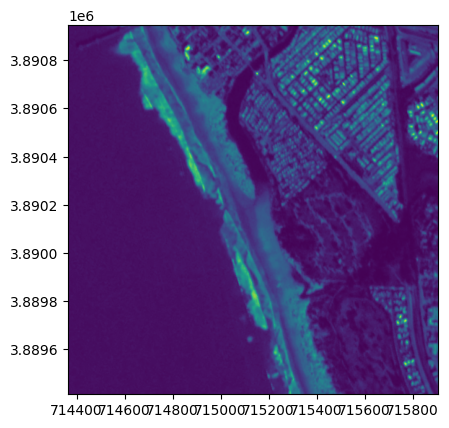

In [153]:
with rasterio.open(pth) as src:
    bounds = src.bounds
    crs = src.crs

    transformer = Transformer.from_crs(crs, 4326)
    # Calculate centroid
    centroid_x = (bounds.left + bounds.right) / 2
    centroid_y = (bounds.top + bounds.bottom) / 2
    centroid_x, centroid_y = transformer.transform(centroid_x, centroid_y)
    bounds_b, bounds_l = transformer.transform(bounds.left, bounds.bottom)
    bounds_t, bounds_r = transformer.transform(bounds.right, bounds.top)

    bounds_g = [bounds_b, bounds_l, bounds_t, bounds_r]
    cent_g = centroid_x, centroid_y

    plt.figure()
    show((src, 1), cmap='viridis')

    data = src.read()
    data = data[:, :512, :512]
    

In [193]:
def normalize_latlon(lat, lon):
    """
    Normalize latitude and longitude to a range between -1 and 1.

    Parameters:
    lat (float): Latitude value.
    lon (float): Longitude value.

    Returns:
    tuple: Normalized latitude and longitude values.
    """
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))

def prep_datacube(image, lat, lon, date):
    """
    Prepare a data cube for model input.

    Parameters:
    image (np.array): The input image array.
    lat (float): Latitude value for the location.
    lon (float): Longitude value for the location.

    Returns:
    dict: Prepared data cube with normalized values and embeddings.
    """
    md = metadata['planetscope-sr-4']

    # Extract mean, std, and wavelengths from metadata
    mean = []
    std = []
    waves = []
    bands = md['band_order']
    for band_name in bands:
        mean.append(md['bands']['mean'][band_name])
        std.append(md['bands']['std'][band_name])
        waves.append(md['bands']['wavelength'][band_name] * 1000)

    transform = v2.Compose(
        [
            v2.Resize(size=(128, 128), interpolation=3),
            v2.Normalize(mean=mean, std=std),
        ]
    )

    # Prep datetimes embedding
    times = normalize_timestamp(date)
    week_norm = times[0]
    hour_norm = times[1]

    # Prep lat/lon embedding
    latlons = normalize_latlon(lat, lon)
    lat_norm = latlons[0]
    lon_norm = latlons[1]

    # Prep pixels
    pixels = torch.from_numpy(image.astype(np.float32))
    pixels = transform(pixels)
    pixels = pixels.unsqueeze(0)

    # Prepare additional information
    return {
        "pixels": pixels,
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
        ).unsqueeze(0),
        "latlon": torch.tensor(
            np.hstack((lat_norm, lon_norm)), dtype=torch.float32
        ).unsqueeze(0),
        "waves": torch.tensor(waves),
        "gsd": torch.tensor(md['gsd'] * 2).unsqueeze(0),
    }

In [199]:
model.model.patch_size

8

In [194]:
datacube = prep_datacube(data, *cent_g, dt)
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

In [197]:
print(unmsk_patch.shape)

torch.Size([1, 257, 1024])


In [67]:
# The first embedding is the class token, which is the overall single embedding.
unmsk_patch[:, 0, :].cpu().numpy()

array([[ 0.00199498, -0.0864813 , -0.0521516 , ...,  0.02617873,
         0.05235796,  0.02052316]], dtype=float32)

In [99]:
ep_embedder_cpu = torch.export.load("/Users/kyledorman/data/models/clay/clay-v1.5-encoder_256.pt2").module()

In [101]:
%%time
datacube = prep_datacube(data, *cent_g, dt)
with torch.no_grad():
    embeddings = ep_embedder_cpu(datacube)
datacube["pixels"].shape, embeddings.shape

CPU times: user 1.93 s, sys: 381 ms, total: 2.31 s
Wall time: 640 ms


(torch.Size([1, 4, 256, 256]), torch.Size([1, 1024]))

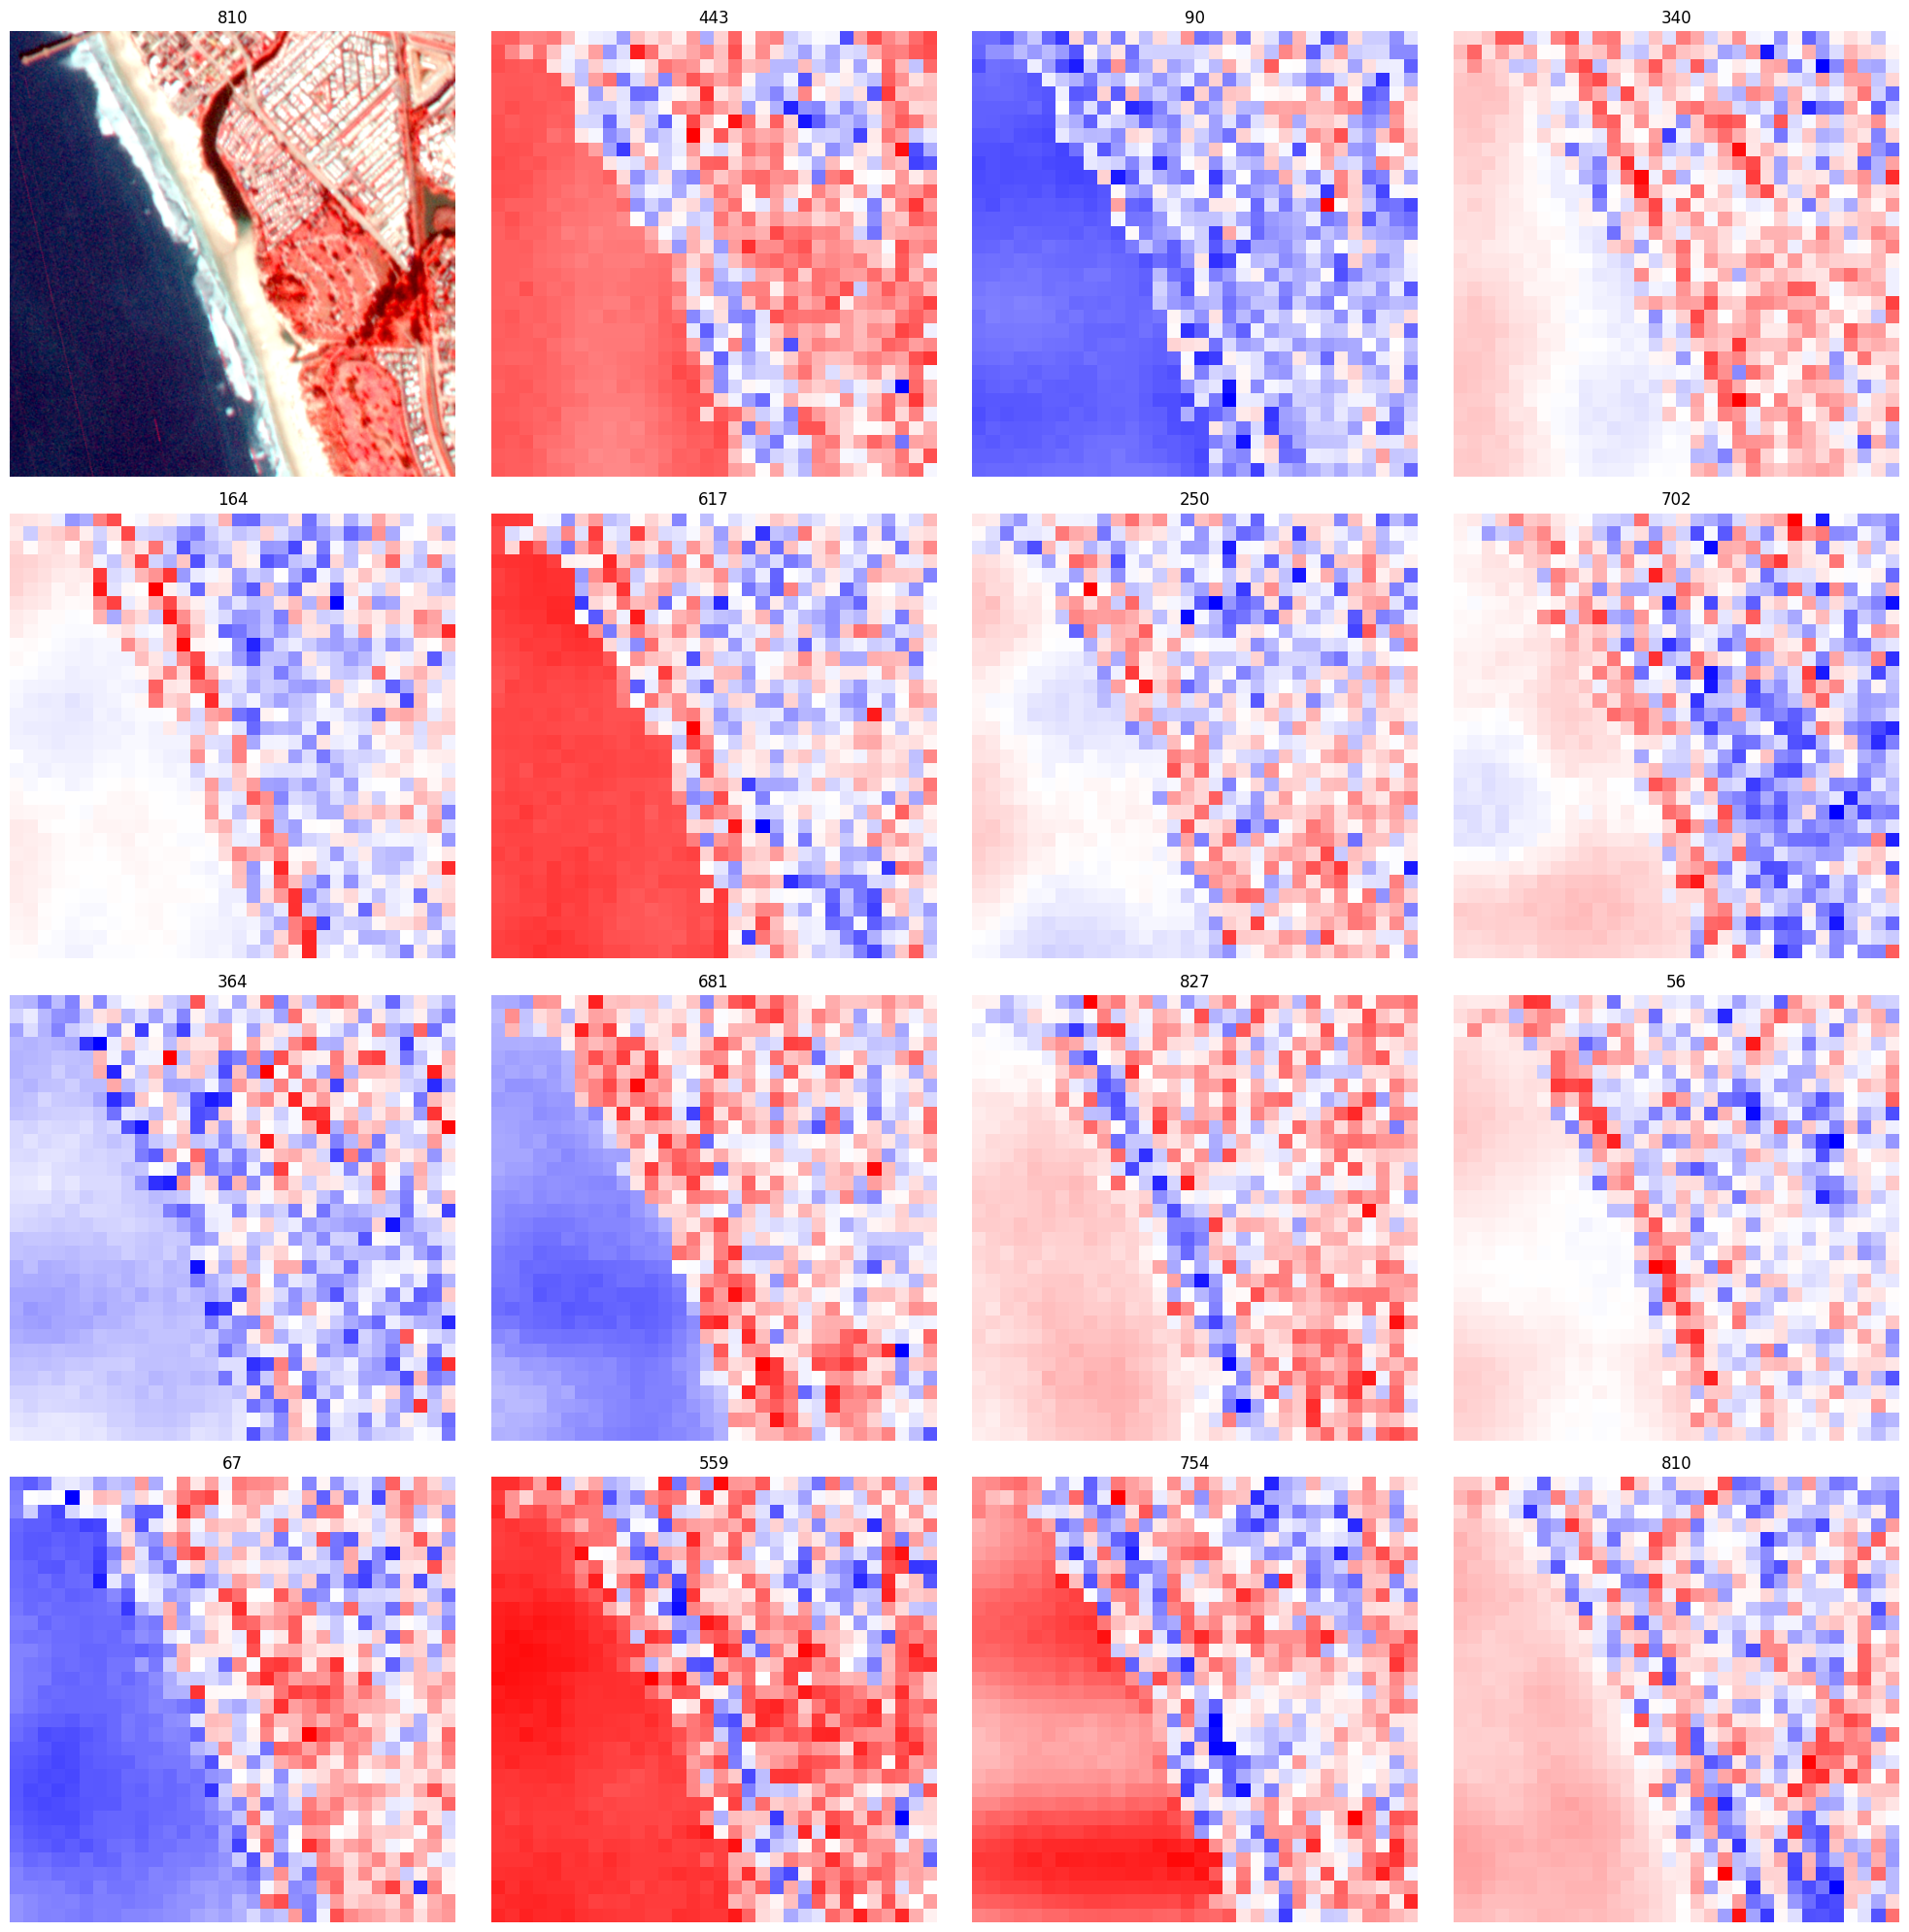

In [115]:
from einops import rearrange

size = 32

embed = rearrange(
    unmsk_patch[:, 1:, :].detach().cpu().numpy(), "b (h w) d-> b d h w", h=size, w=size
)
embed = embed[0]
rows = 4
cols = 4
fig, axs = plt.subplots(cols, cols, figsize=(20, 20))

# idxes = np.random.choice(unmsk_patch.shape[2], rows * cols - 1, replace=False)

for idx, ax in zip(idxes, axs.flatten()[1:]):
    ax.imshow(embed[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)

ax = axs.flatten()[0]
dd = np.log10(1 + data[[3, 2, 1]].clip(1, 2000))
dd = contrast_stretch(dd)
show(dd, ax=ax)
ax.set_axis_off()
ax.set_title(idx)

plt.tight_layout()

In [215]:
from sklearn import decomposition, svm
import pandas as pd
labels = pd.read_csv("/Users/kyledorman/data/estuary/label_studio/00025/labels.csv")
labels

,region,source_tif,source_jpeg,label
0,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
1,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,closed
2,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
3,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,closed
4,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
...,...,...,...,...
2995,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
2996,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
2997,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,closed
2998,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open


Matched 229 out of 295 correctly
Accuracy 0.7762711864406779
F1 0.691
Precision 0.795
Recall 0.675


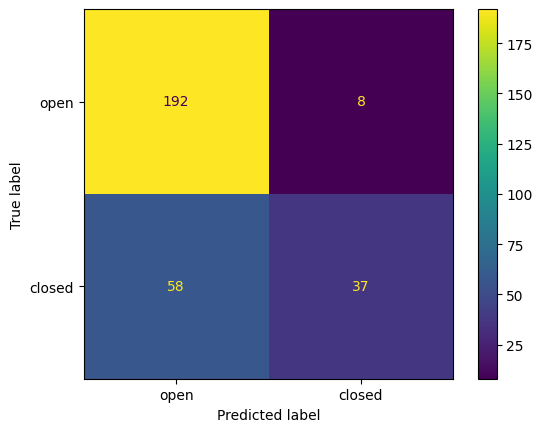

In [229]:
# Predict classes on test set
prediction = clf.predict(X_test)

# Perfect match for SVM
match = np.sum(y_test == prediction)
print(f"Matched {match} out of {len(X_test)} correctly")

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

_ = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    prediction, 
    labels=list(range(len(["open", "closed"]))),
    display_labels=["open", "closed"],
)

print("Accuracy", accuracy_score(y_test, prediction))
prfs = precision_recall_fscore_support(y_test, prediction, average='macro')
print("F1", round(prfs[2], 3))
print("Precision", round(prfs[0], 3))
print("Recall", round(prfs[1], 3))

In [230]:
from estuary.clay.module import EstuaryModule

module = EstuaryModule.load_from_checkpoint("/Users/kyledorman/data/results/estuary/train/20250805-205230/checkpoints/epoch=33-step=5032.ckpt")

In [245]:
from estuary.clay.data import EstuaryDataModule

dm = EstuaryDataModule(module.conf)
dm.prepare_data()
dm.setup()

Some label classes will be ignored {'unsure'}


In [247]:
import tqdm

dl = dm.test_dataloader()

preds = []

for batch, _ in tqdm.tqdm(dl, total=len(dl)):
    for k in batch.keys():
        batch[k] = batch[k].to(module.device)
    pred_batch = module.forward(batch)
    preds.extend(pred_batch.argmax(axis=1).detach().cpu().numpy().tolist())
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.36s/it]


In [273]:
label_df = dm.test_ds.df
X_test = []
for _, row in label_df.iterrows():
    pth = Path(row.source_jpeg)
    emb_pth = pth.parent.parent / "embeddings" / f"{pth.stem}.npy"
    emb = np.load(emb_pth)
    X_test.append(emb)
X_test = np.array(X_test)
y_test = np.array(label_df.label_idx.tolist())

label_df = dm.train_ds.df
X_train = []
for _, row in label_df.iterrows():
    pth = Path(row.source_jpeg)
    emb_pth = pth.parent.parent / "embeddings" / f"{pth.stem}.npy"
    emb = np.load(emb_pth)
    X_train.append(emb)
X_train = np.array(X_train)
y_train = np.array(label_df.label_idx.tolist())

In [274]:
from sklearn.ensemble import RandomForestClassifier

clf = svm.SVC()
# clf = RandomForestClassifier()
clf.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Matched 235 out of 295 correctly
Accuracy 0.7966101694915254
F1 0.713
Precision 0.824
Recall 0.692


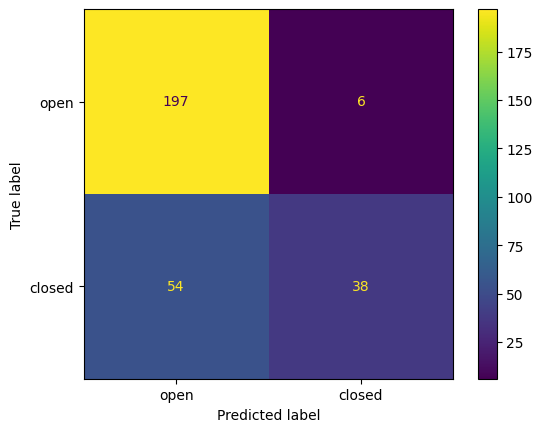

In [275]:
# Predict classes on test set
svn_pred = clf.predict(X_test)
y_test = dm.test_ds.df.label_idx
# Perfect match for SVM
match = np.sum(y_test == svn_pred)
print(f"Matched {match} out of {len(X_test)} correctly")

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

_ = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    svn_pred, 
    labels=list(range(len(["open", "closed"]))),
    display_labels=["open", "closed"],
)

print("Accuracy", accuracy_score(y_test, svn_pred))
prfs = precision_recall_fscore_support(y_test, svn_pred, average='macro')
print("F1", round(prfs[2], 3))
print("Precision", round(prfs[0], 3))
print("Recall", round(prfs[1], 3))

In [284]:
pred_df = pd.DataFrame(
    list(zip(
        preds,
        svn_pred,
        dm.test_ds.df.label_idx.tolist(),
        dm.test_ds.df.region.tolist(),
        dm.test_ds.df.source_jpeg.tolist(),
    )), 
    columns=['dnn', 'svn', 'label', 'region', 'source_jpeg']
)
# Define a function to compute accuracy per group
def compute_accuracy(group, pred_col):
    return accuracy_score(group['label'], group[pred_col])

# Group by region and compute accuracy
dnn_acc_by_region = pred_df.groupby('region').apply(lambda g: compute_accuracy(g, 'dnn'))
svn_acc_by_region = pred_df.groupby('region').apply(lambda g: compute_accuracy(g, 'svn'))

# Combine into a DataFrame for display
acc_df = pd.DataFrame({
    'dnn_accuracy': dnn_acc_by_region,
    'svn_accuracy': svn_acc_by_region
}).reset_index()

# Show the result
print(acc_df.round(3))

print("dnn accuracy", round(f1_score(pred_df.label, pred_df.dnn), 3))
print("svn accuracy", round(f1_score(pred_df.label, pred_df.svn), 3))

                    region  dnn_accuracy  svn_accuracy
0            big_sur_river         0.913         0.783
1                   carmel         1.000         1.000
2                   goleta         1.000         0.941
3               little_sur         0.950         0.700
4   los_penasquitos_lagoon         0.958         0.833
5            malibu_lagoon         1.000         0.619
6            navarro_river         0.938         0.125
7       pismo_creek_lagoon         0.929         0.714
8            russian_river         0.944         0.889
9      san_dieguito_lagoon         1.000         1.000
10        san_elijo_lagoon         1.000         0.947
11        san_mateo_lagoon         0.962         0.885
12         santa_margarita         1.000         1.000
13                 topanga         1.000         0.769
14                 ventura         1.000         0.722
dnn accuracy 0.951
svn accuracy 0.559


/var/folders/pr/1dt1qk511zdgzhfy1xskpqm00000gn/T/ipykernel_73120/1729867315.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dnn_acc_by_region = pred_df.groupby('region').apply(lambda g: compute_accuracy(g, 'dnn'))
/var/folders/pr/1dt1qk511zdgzhfy1xskpqm00000gn/T/ipykernel_73120/1729867315.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  svn_acc_by_region = pred_df.groupby('region').apply(lambda g: compute_ac

In [287]:
labels = pd.read_csv("/Users/kyledorman/data/estuary/label_studio/00025/labels.csv")
for r, g in labels.groupby("region"):
    print(r, round((g.label == "closed").sum() / len(g.label), 3))

big_sur_river 0.12
carmel 0.675
goleta 0.22
little_sur 0.24
los_penasquitos_lagoon 0.145
malibu_lagoon 0.405
navarro_river 0.555
pismo_creek_lagoon 0.33
russian_river 0.13
san_dieguito_lagoon 0.0
san_elijo_lagoon 0.075
san_mateo_lagoon 0.85
santa_margarita 0.04
topanga 0.705
ventura 0.145


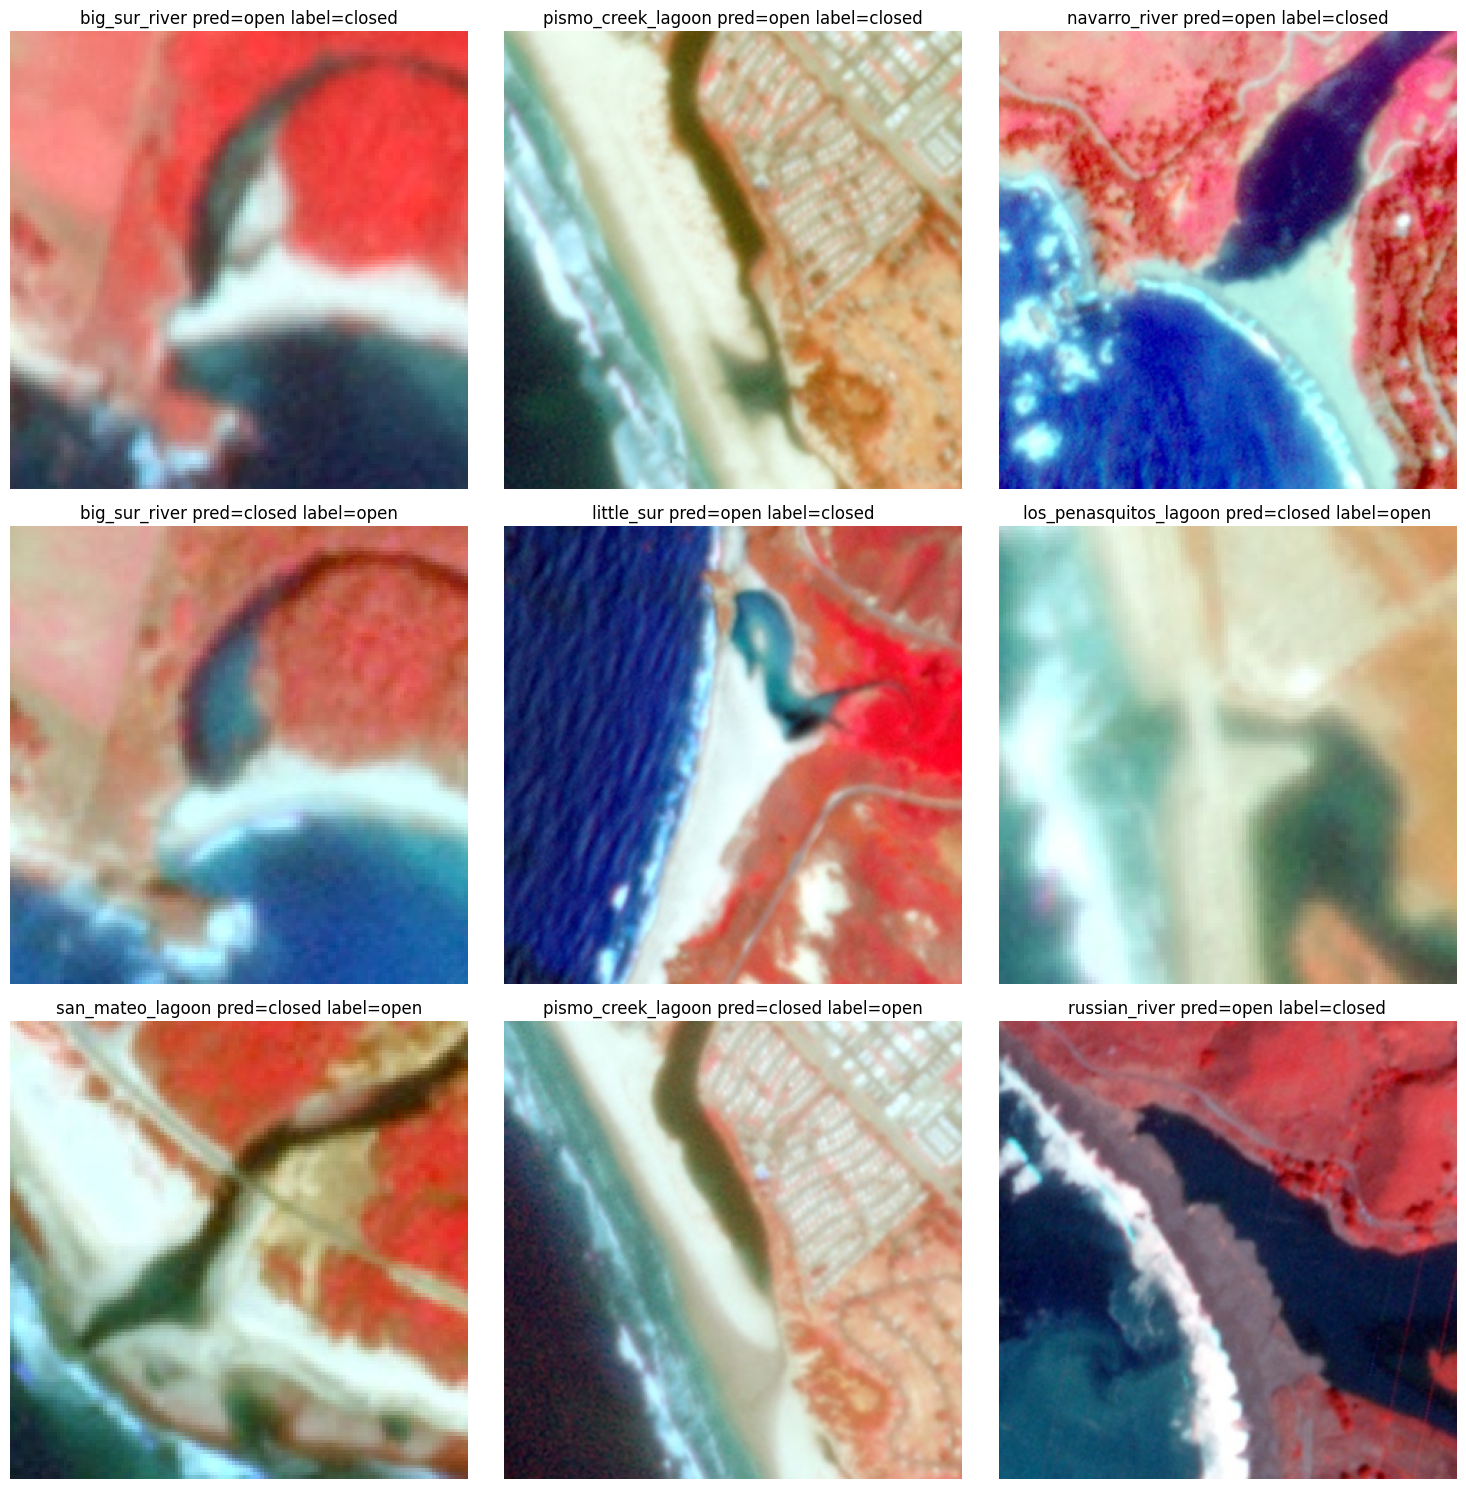

In [283]:
from PIL import Image
aaa = pred_df[(pred_df.dnn != pred_df.label)]

rows = 3
cols = 3
fig, axs = plt.subplots(cols, cols, figsize=(15, 15))

for (idx, row), ax in zip(aaa.iterrows(), axs.flatten()):
    ax.imshow(Image.open(row.source_jpeg))
    ax.set_axis_off()
    ax.set_title(f"{row.region} pred={module.conf.classes[row.dnn]} label={module.conf.classes[row.label]}")

plt.tight_layout()

In [291]:
from estuary.clay.data import *

In [ ]:
dm = 